In [368]:
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [369]:
import yfinance as yf
import pandas as pd

In [370]:
symbols = [ 'TSLA']
start = '2024-01-01'
end='2024-02-29'

In [371]:
data = pd.DataFrame()
for sym in symbols:
    data[sym] = yf.download(sym, start, end)['Adj Close']
data.dropna()

[*********************100%%**********************]  1 of 1 completed


,TSLA
Date,
2024-01-02,248.419998
2024-01-03,238.449997
2024-01-04,237.929993
2024-01-05,237.490005
2024-01-08,240.449997
2024-01-09,234.960007
2024-01-10,233.940002
2024-01-11,227.220001
2024-01-12,218.889999


In [372]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34 entries, 2024-01-02 to 2024-02-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TSLA    34 non-null     float64
dtypes: float64(1)
memory usage: 544.0 bytes


In [373]:
data.head()

,TSLA
Date,
2024-01-02,248.419998
2024-01-03,238.449997
2024-01-04,237.929993
2024-01-05,237.490005
2024-01-08,240.449997


<Axes: xlabel='Date'>

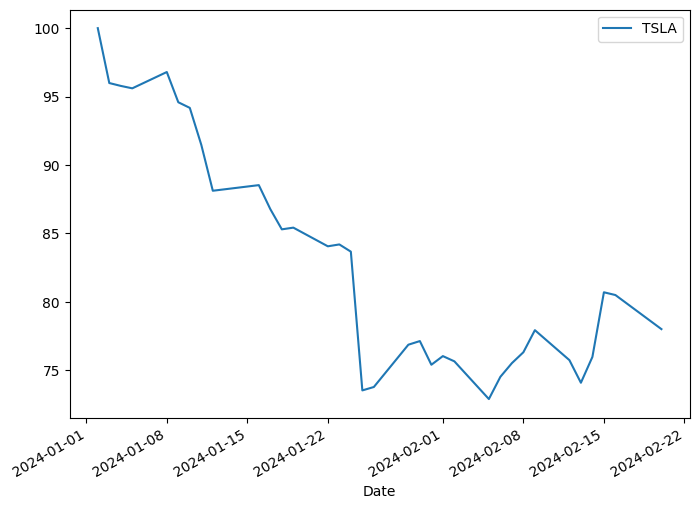

In [374]:
(data / data.iloc[0] * 100).plot(figsize=(8, 6))

In [375]:
log_returns = np.log(data / data.shift(1))
log_returns.head()

,TSLA
Date,
2024-01-02,NaN
2024-01-03,-0.040961
2024-01-04,-0.002183
2024-01-05,-0.001851
2024-01-08,0.012387


array([[<Axes: title={'center': 'TSLA'}>]], dtype=object)

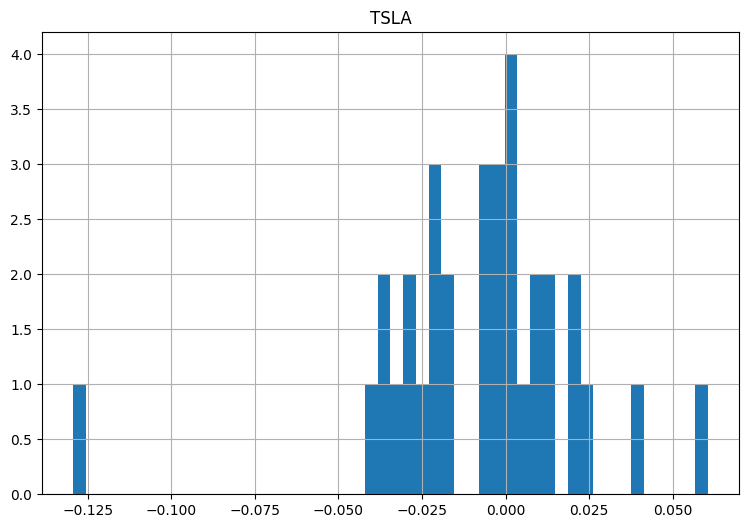

In [376]:
log_returns.hist(bins=50, figsize=(9, 6))

In [377]:
for sym in symbols:
    print("\nResults for symbols %s" % sym)
    print(30 * "-")
    log_data = np.array(log_returns[sym].dropna())
    print_statistics(log_data)


Results for symbols TSLA
------------------------------
     statistic           value
------------------------------
          size              33
           min -0.12925817170128795
14max 0.06035334314528131
14mean -0.007530321311842889
14std 0.03161108520408108
14skew -1.4021518591688573
14kurtosis 5.173848729893622


Text(0, 0.5, 'sample Quantiles')

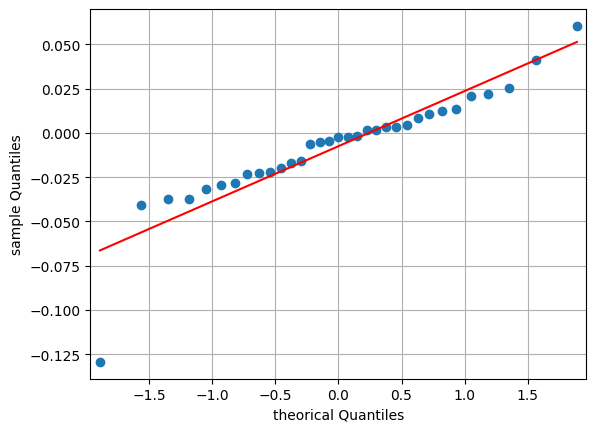

In [379]:
sm.qqplot(log_returns['TSLA'].dropna(), line='s')
plt.grid(True)
plt.xlabel('theorical Quantiles')
plt.ylabel('sample Quantiles')

In [380]:
for sym in symbols :
    print("\nResults for symbols %s" % sym)
    print(32 * "-")
    log_data = np.array(log_returns[sym].dropna())
    normality_tests(log_data)


Results for symbols TSLA
--------------------------------
Skew of data set         -1.402
Skew test p-value          0.002
Kurt of data set          5.174
kurt test p-value          0.001
Norm test p-value          0.000


# **Portfolio Optimization**

In [381]:
log_returns.mean() * 252

TSLA   -1.897641
dtype: float64

In [ ]:
log_returns.std() * 252

In [383]:
noa = len(symbols)

In [384]:
weights = np.random.random(noa)
weights /= np.sum(weights)

In [385]:
weights

array([1.])

In [386]:
np.sum(log_returns.mean() * weights) * 252

-1.897640970584408

In [387]:
np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))

0.2518136983604779

In [388]:
np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))

0.5018104207372321

In [389]:
prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(log_returns.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))))


prets = np.array(prets)
pvols = np.array(pvols)



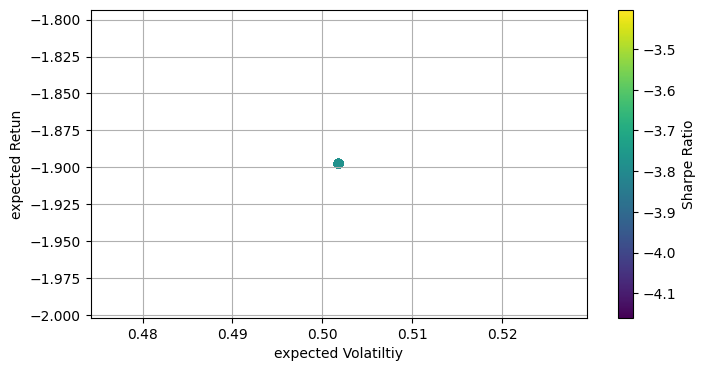

In [390]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('expected Volatiltiy')
plt.ylabel('expected Retun')
plt.colorbar(label='Sharpe Ratio')

In [391]:
data.corr()

,TSLA
TSLA,1.0


In [392]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(log_returns.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [393]:
import scipy.optimize as sco

In [394]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [395]:
cons = ({'type': 'eq', 'fun': lambda x : np.sum(x) - 1})

In [396]:
bnds = tuple((0, 1) for x in range(noa))

In [397]:
noa * [1. / noa, ]

[1.0]

In [398]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                    bounds=bnds, constraints=cons)

CPU times: user 3.99 ms, sys: 1.02 ms, total: 5.01 ms
Wall time: 4.77 ms


In [399]:
opts

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.7815894054103114
       x: [ 1.000e+00]
     nit: 1
     jac: [-2.980e-08]
    nfev: 2
    njev: 1

In [400]:
opts['x'].round(3)

array([1.])

In [401]:
statistics(opts['x']).round(3)

array([-1.898,  0.502, -3.782])